In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, applications
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import os


In [2]:
# Check for GPU availability
if not tf.config.list_physical_devices('GPU'):
    raise SystemError("GPU not found! Please enable GPU in Kaggle settings.")
    
print("GPU is available and the notebook will run on GPU.")

GPU is available and the notebook will run on GPU.


In [3]:
# Set dataset path (change if needed)
dataset_path = r"/kaggle/input/recycle-dataset/TrashType_Image_Dataset"

In [4]:
# Hyperparameters
batch_size = 32
img_size = (224, 224)
epochs = 20
num_classes = 6  # Classes: 1.cardboard, 2.glass, 3.metal, 4.paper, 5.plastic, 6.trash

In [5]:
# Load dataset
dataset = image_dataset_from_directory(
    dataset_path,
    shuffle=True,
    batch_size=batch_size,
    image_size=img_size
)


Found 2527 files belonging to 6 classes.


In [6]:
# Class names
class_names = dataset.class_names
print("Class names:", class_names)


Class names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [7]:
# Determine training size (80% train, 20% validation)
train_size = int(0.8 * len(dataset))

# Split dataset using take() and skip()
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)


In [8]:
# Load VGG-19 model (without top layers)
vgg19_base = tf.keras.applications.VGG19(
    weights='imagenet',  # Use pretrained ImageNet weights
    include_top=False,    # Remove default classification head
    input_shape=(224, 224, 3)
)


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [9]:
# Freeze VGG-19 base model to retain pretrained features
vgg19_base.trainable = False  


In [15]:
# Build model using VGG-19 as a feature 
from tensorflow.keras.layers import Flatten

inputs = keras.Input(shape=(224, 224, 3))
x = layers.Rescaling(1./255)(inputs)  # Normalize input images
x = vgg19_base(x, training=False)  # Pass through VGG-19
x = layers.TimeDistributed(layers.Flatten())(x)  # Flatten output while keeping time steps
x = layers.LSTM(16, return_sequences=False)(x)  # LSTM for sequential processing
x = layers.Dense(64, activation="relu")(x)  # Fully connected layer


outputs = layers.Dense(num_classes, activation='softmax')(x)  # Output layer for 6 classes

In [16]:
# Create the model
model = keras.Model(inputs=inputs, outputs=outputs)

In [17]:
# Compile model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [20]:
# Train model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=50)


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.9777 - loss: 0.0850 - val_accuracy: 0.8395 - val_loss: 0.5643
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.9882 - loss: 0.0538 - val_accuracy: 0.8395 - val_loss: 0.5837
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.9878 - loss: 0.0526 - val_accuracy: 0.8219 - val_loss: 0.6239
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.9905 - loss: 0.0490 - val_accuracy: 0.7828 - val_loss: 0.8359
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.9519 - loss: 0.1184 - val_accuracy: 0.8278 - val_loss: 0.6821
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.9876 - loss: 0.0516 - val_accuracy: 0.8454 - val_loss: 0.5702
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 0.9954 - loss: 0.0251 - val_accuracy: 0.8454 - val_loss: 0.6190
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.9915 - loss: 0.0314 - val_accuracy: 0.

In [23]:
test_loss, test_accuracy = model.evaluate(val_dataset)
print(f"Test Accuracy (Raw): {test_accuracy}")
print(f"Test Accuracy (Formatted): {test_accuracy * 100:.2f}%")


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.9121 - loss: 0.4346
Test Accuracy (Raw): 0.859099805355072
Test Accuracy (Formatted): 85.91%


In [24]:
# Save the model
model.save("/kaggle/working/recycle.h5")

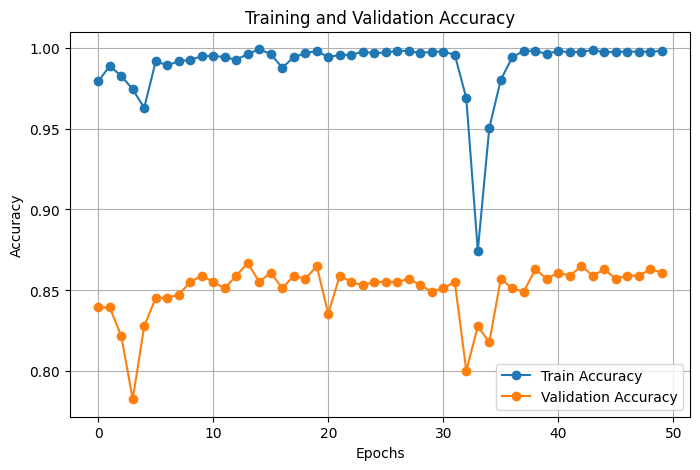

In [25]:
# Plot training & validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title("Training and Validation Accuracy")
plt.show()


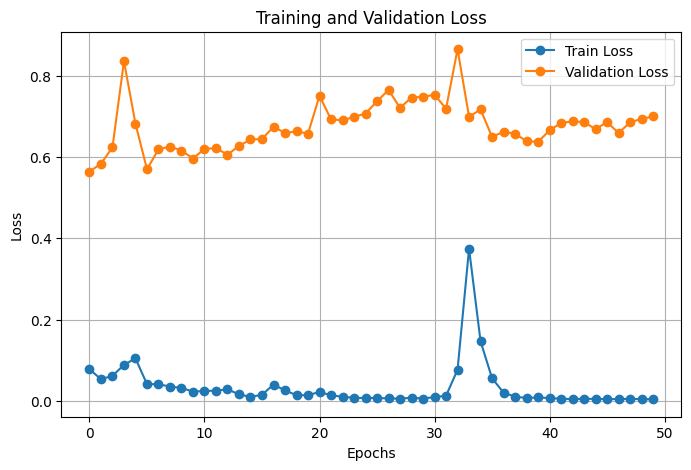

In [26]:
# Plot training & validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title("Training and Validation Loss")
plt.show()
